C:\Users\shire\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


C:\Users\shire\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1583/1583 ━━━━━━━━━━━━━━━━━━━━ 153s 87ms/step - accuracy: 0.5382 - loss: 0.6936 - val_accuracy: 0.5877 - val_loss: 0.6642 - learning_rate: 0.0010
Epoch 2/50
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 103s 65ms/step - accuracy: 0.6117 - loss: 0.6621 - val_accuracy: 0.6652 - val_loss: 0.6305 - learning_rate: 0.0010
Epoch 3/50
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 103s 65ms/step - accuracy: 0.6553 - loss: 0.6399 - val_accuracy: 0.6562 - val_loss: 0.6280 - learning_rate: 0.0010
Epoch 4/50
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 105s 66ms/step - accuracy: 0.6665 - loss: 0.6276 - val_accuracy: 0.6682 - val_loss: 0.6211 - learning_rate: 0.0010
Epoch 5/50
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 104s 66ms/step - accuracy: 0.6716 - loss: 0.6203 - val_accuracy: 0.6747 - val_loss: 0.6176 - learning_rate: 0.0010
Epoch 6/50
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 104s 66ms/step - accuracy: 0.6773 - loss: 0.6131 - val_accuracy: 0.6815 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 7/50
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 106s 67ms/step - accuracy: 

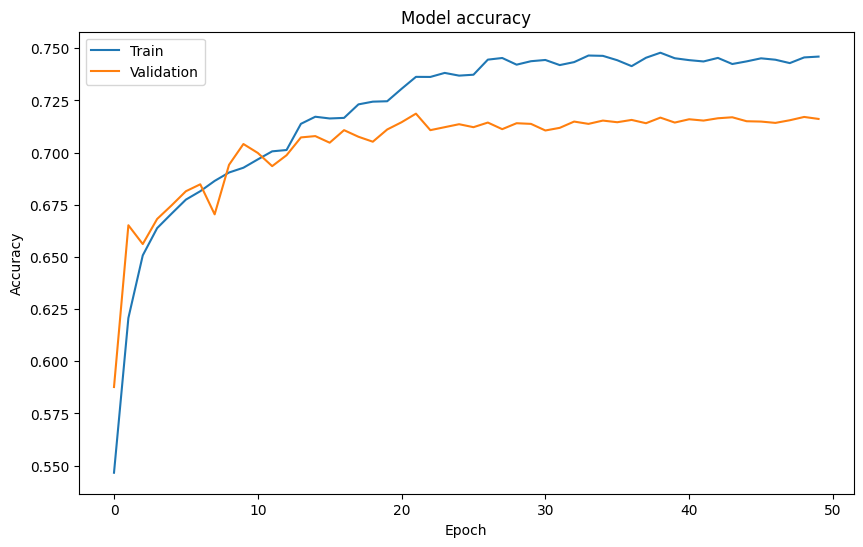

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, Bidirectional, LSTM
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau
from gensim.models import Word2Vec

# Step 1: Data Preprocessing
def read_dataset(file_path):
    ids, sequences, classes = [], [], []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 3):
            ids.append(lines[i].strip())
            sequences.append(lines[i+1].strip())
            classes.append(lines[i+2].strip())
    return ids, sequences, classes

def kmer_encoding(sequence, k=4):
    kmers = [sequence[x:x+k] for x in range(len(sequence) - k + 1)]
    return kmers

# Load dataset
file_path = r'C:\\Users\\shire\\OneDrive\\Desktop\\Project\\dataset.txt'
ids, sequences, classes = read_dataset(file_path)

# Create k-mers for all sequences
all_kmers = [kmer_encoding(seq) for seq in sequences]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=all_kmers, vector_size=100, window=5, min_count=1, sg=1)
word_vectors = w2v_model.wv

# Create a dictionary to map k-mers to Word2Vec vectors
kmer_to_vec = {kmer: word_vectors[kmer] for kmer in word_vectors.index_to_key}

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(classes)
encoded_labels = to_categorical(encoded_labels)

# Train-test split
X_train_seqs, X_val_seqs, y_train, y_val = train_test_split(sequences, encoded_labels, test_size=0.2, random_state=42)

# Step 2: Data Generator
class DataGenerator(Sequence):
    def __init__(self, sequences, labels, kmer_to_vec, batch_size=16, k=4, shuffle=True):
        self.sequences = sequences
        self.labels = labels
        self.batch_size = batch_size
        self.k = k
        self.shuffle = shuffle
        self.kmer_to_vec = kmer_to_vec
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.sequences) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_sequences = [self.sequences[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]
        
        X, y = self.__data_generation(batch_sequences, batch_labels)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.sequences))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_sequences, batch_labels):
        X = []
        for seq in batch_sequences:
            kmers = kmer_encoding(seq)
            vecs = [self.kmer_to_vec[kmer] for kmer in kmers]
            X.append(vecs)
        X = np.array(X)
        y = np.array(batch_labels)
        return X, y

# Initialize data generators
training_generator = DataGenerator(X_train_seqs, y_train, kmer_to_vec, batch_size=16)
validation_generator = DataGenerator(X_val_seqs, y_val, kmer_to_vec, batch_size=16)

# Step 3: Model Building
def build_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))  # Added dropout layer
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))  # Added dropout layer
    
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.5))  # Added dropout layer
    
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.5))  # Added dropout layer
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define input shape and number of classes
sequence_length = len(kmer_encoding(sequences[0]))  # Length of the sequence after k-mer encoding
input_shape = (sequence_length, 100)  # Timesteps, features (Word2Vec vector size)
num_classes = y_train.shape[1]
model = build_model(input_shape, num_classes)

# Step 4: Training and Evaluation

# Learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model using generators
history = model.fit(training_generator, validation_data=validation_generator, epochs=50, callbacks=[reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.4f}')

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
